# 数据挖掘作业二

## 姓名：林宁 学号：3220190838

数据集: Wine Reviews

In [1]:
# 导入必要的包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False

### 1、对数据集进行处理，转换成适合关联规则挖掘的形式

#### 1.1 读取数据集

In [2]:
wine = pd.read_csv(".\dataset\wine-reviews\winemag-data_first150k.csv",header=0,sep='',delimiter=",", encoding='utf-8')

#### 1.2 去除数据中缺失值

In [3]:
# 去除数据中的缺失值 
wine = wine.dropna()
wine.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
8,8,US,This re-named vineyard was formerly bottled as...,Silice,95,65.0,Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
9,9,US,The producer sources from two blocks of the vi...,Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm


#### 1.3 对数值属性进行离散化处理 

由于 points 和 price 属性列为连续的数值属性，需要进行离散化处理

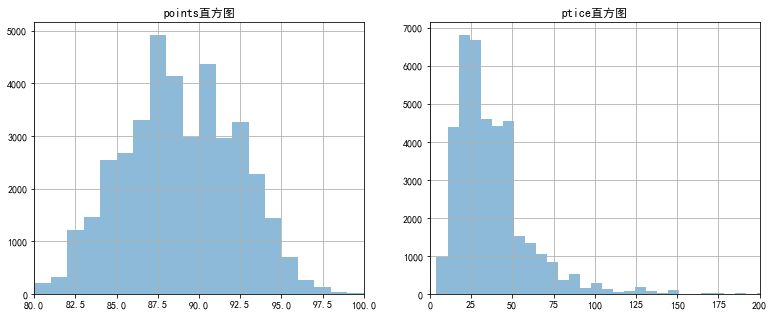

In [4]:
# 利用直方图观察数据分布
plt.figure(figsize=(13, 5))
#直方图绘制
plt.subplot(1,2,1)
plt.title("points直方图")
plt.xlim(80,100)
wine['points'].hist(alpha=0.5,bins=20)

#直方图绘制
plt.subplot(1,2,2)
plt.title("ptice直方图")
plt.xlim(0,200)
wine['price'].hist(alpha=0.5,bins=300)
plt.show()

In [5]:
# 对数据进行离散化处理
bin = [0,75,80,85,90,95,100]
wine['points'] = pd.cut(wine['points'],bin)
wine['points'] = wine['points'].astype('str')
bin = [0,20,30,40,50,60,250]
wine['price'] = pd.cut(wine['price'],bin)
wine['price'] = wine['price'].astype('str')

#### 1.4 去除数据集中一些属性，缩小搜索空间

In [6]:
wine = wine.drop(columns=['Unnamed: 0','description'])
wine.head()

,country,designation,points,price,province,region_1,region_2,variety,winery
0,US,Martha's Vineyard,"(95, 100]","(60, 250]",California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
2,US,Special Selected Late Harvest,"(95, 100]","(60, 250]",California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,Reserve,"(95, 100]","(60, 250]",Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
8,US,Silice,"(90, 95]","(60, 250]",Oregon,Chehalem Mountains,Willamette Valley,Pinot Noir,Bergström
9,US,Gap's Crown Vineyard,"(90, 95]","(50, 60]",California,Sonoma Coast,Sonoma,Pinot Noir,Blue Farm


### 2、找出频繁项集

#### 2.1 使用Apriori算法提取频繁项集

Apriori算法的缺点是需要不断扫描数据集，不断地求候选项集的支持度从而判断它是否是频繁项集。当数据集很大的时候，这种算法的效率将会非常低。

In [7]:
def createC1( dataSet ):
    """
    构建 频繁 1-项集
    """
    C1 = []
    for transaction in np.array(dataSet):
        for item in transaction:
            if [item] not in C1:
                C1.append( [item] )
    C1.sort()
    return list(map( frozenset, C1 ))

def scanD( D, Ck, minSupport ):
    """
    计算Ck中的项集在数据集合D(记录或者transactions)中的支持度,
    返回满足最小支持度的项集的集合，和所有项集支持度信息的字典。
    """
    ssCnt = {}
    for tid in D:
        # 对于每一条transaction
        if Ck is not None:
            for can in Ck:
                # 对于每一个候选项集can，检查是否是transaction的一部分
                # 即该候选can是否得到transaction的支持
                if can.issubset( tid ):
                    ssCnt[ can ] = ssCnt.get( can, 0) + 1
    numItems = float( len( D ) )
    retList = []
    supportData = {}
    for key in ssCnt:
        # 每个项集的支持度
        support = ssCnt[ key ] / numItems
        
        # 将满足最小支持度的项集，加入retList
        if support >= minSupport:
            retList.insert( 0, key )
            
            # 汇总支持度数据
            supportData[ key ] = support
    return retList, supportData

In [8]:
def aprioriGen( Lk, k ):
    '''
    由初始候选项集的集合Lk生成新的生成候选项集，
    k表示生成的新项集中所含有的元素个数
    '''
    retList = []
    lenLk = len( Lk )
    for i in range( lenLk ):
        for j in range( i + 1, lenLk ):
            L1 = list( Lk[ i ] )[ : k - 2 ];
            L2 = list( Lk[ j ] )[ : k - 2 ];
            L1.sort();L2.sort()    
            if L1==L2:
                retList.append( Lk[ i ] | Lk[ j ] ) 
    return retList

def apriori( dataSet, minSupport = 0.5 ):
    # 构建初始候选项集C1
    C1 = createC1( dataSet )
    
    # 将dataSet集合化，以满足scanD的格式要求
    D =list( map( set, dataSet ))
    
    # 构建初始的频繁项集，即所有项集只有一个元素
    L1, suppData = scanD( D, C1, minSupport )
    L = [ L1 ]
    # 最初的L1中的每个项集含有一个元素，新生成的
    # 项集应该含有2个元素，所以 k=2
    k = 2
    
    while ( len( L[ k - 2 ] ) > 0 ):
        Ck = aprioriGen( L[ k - 2 ], k )
        Lk, supK = scanD( D, Ck, minSupport )
        
        # 将新的项集的支持度数据加入原来的总支持度字典中
        suppData.update( supK )
        
        # 将符合最小支持度要求的项集加入L
        L.append( Lk )
        
        # 新生成的项集中的元素个数应不断增加
        k += 1
    # 返回所有满足条件的频繁项集的列表，和所有候选项集的支持度信息
    return L, suppData

In [9]:
myDat = list(map(set,np.array(wine)))
L, suppData = apriori(myDat, 0.05)

#### 2.2 查看频繁项集 

In [10]:
L

[[frozenset({'(80, 85]'}),
  frozenset({'Red Blend'}),
  frozenset({'Zinfandel'}),
  frozenset({'Paso Robles'}),
  frozenset({'(0, 20]'}),
  frozenset({'Columbia Valley (WA)'}),
  frozenset({'Russian River Valley'}),
  frozenset({'(85, 90]'}),
  frozenset({'(30, 40]'}),
  frozenset({'Washington'}),
  frozenset({'Syrah'}),
  frozenset({'Columbia Valley'}),
  frozenset({'Central Coast'}),
  frozenset({'(20, 30]'}),
  frozenset({'Chardonnay'}),
  frozenset({'(40, 50]'}),
  frozenset({'(50, 60]'}),
  frozenset({'(90, 95]'}),
  frozenset({'Willamette Valley'}),
  frozenset({'Pinot Noir'}),
  frozenset({'Oregon'}),
  frozenset({'Sonoma'}),
  frozenset({'(60, 210]'}),
  frozenset({'US'}),
  frozenset({'Napa Valley'}),
  frozenset({'Napa'}),
  frozenset({'California'}),
  frozenset({'Cabernet Sauvignon'})],
 [frozenset({'(20, 30]', '(80, 85]'}),
  frozenset({'(80, 85]', 'California'}),
  frozenset({'(80, 85]', 'US'}),
  frozenset({'(80, 85]', 'Central Coast'}),
  frozenset({'(0, 20]', '(80, 85

### 3、导出关联规则，计算其支持度和置信度;

In [11]:
def select_conf(L,suppData,thredhold=0.5):
    confList = []
    for itemSet in L:
        for record in itemSet:
            if(len(record)>1): 
                for i in record: 
                    tar = suppData[frozenset([i])]
                    bset = record - frozenset([i])
                    aset = suppData[record]
                    ret = suppData.get(bset)
                    try:
                        if suppData.get(bset):
                            con = aset/ret
                            if con > thredhold:
                                confList.append([frozenset([i]),'-->',record,'supp:',aset,'con:',con])
                    except TypeError as e:
                        print(e)
    return confList

In [12]:
confList = select_conf(L,suppData)
for item in confList:
    print(item)

[frozenset({'California'}), '-->', frozenset({'(80, 85]', 'California'}), 'supp:', 0.1727020208455442, 'con:', 0.8234507897934387]
[frozenset({'US'}), '-->', frozenset({'(80, 85]', 'US'}), 'supp:', 0.209729619530593, 'con:', 1.0]
[frozenset({'US'}), '-->', frozenset({'US', 'Red Blend'}), 'supp:', 0.07479422033077648, 'con:', 1.0]
[frozenset({'California'}), '-->', frozenset({'Zinfandel', 'California'}), 'supp:', 0.07023266481486201, 'con:', 0.9762663832801985]
[frozenset({'US'}), '-->', frozenset({'Zinfandel', 'US'}), 'supp:', 0.0719400626895339, 'con:', 1.0]
[frozenset({'California'}), '-->', frozenset({'Paso Robles', 'California'}), 'supp:', 0.05338803802145715, 'con:', 1.0]
[frozenset({'US'}), '-->', frozenset({'Paso Robles', 'US'}), 'supp:', 0.05338803802145715, 'con:', 1.0]
[frozenset({'Central Coast'}), '-->', frozenset({'Central Coast', 'Paso Robles'}), 'supp:', 0.05338803802145715, 'con:', 1.0]
[frozenset({'California'}), '-->', frozenset({'(0, 20]', 'California'}), 'supp:', 0.

上面的操作就是导出关联规则并查看对应的支持度和置信度的过程。

其中supp代表支持度、con代表置信度。

### 4、对规则进行评价，可使用Lift及其它指标, 要求至少2种；

#### 4.1 使用lift规则进行评价

lift(A,B)=P(A交B)/(P(A)*P(B))=P(A)*P(B|A)/(P(A)*P(B))=P(B|A)/P(B)=confidence(A—>B)/support(B)=confidence(B—>A)/support(A)

In [13]:
#Lift相关系数检验
def liftCheck(conList,suppData):
    liftList_true=[]
    liftList_no=[]
    liftList_false=[]
    for item in confList:
        score = suppData.get(item[2])/(suppData.get(item[0])*suppData.get(item[2]-item[0]))
        if score>1:
            liftList_true.append(['提升度为:{0}'.format(score),item])
        if score<1:
            liftList_false.append(['提升度为:{0}'.format(score),item])
        if score ==1:
            liftList_no.append(['提升度为:{0}'.format(score),item])
    return liftList_true,liftList_no,liftList_false

In [14]:
yes,no,false = liftCheck(confList,suppData)
for item in yes:
    print(item)

['提升度为:1.1315275568961842', [frozenset({'California'}), '-->', frozenset({'(80, 85]', 'California'}), 'supp:', 0.1727020208455442, 'con:', 0.8234507897934387]]
['提升度为:1.341515885642689', [frozenset({'California'}), '-->', frozenset({'Zinfandel', 'California'}), 'supp:', 0.07023266481486201, 'con:', 0.9762663832801985]]
['提升度为:1.3741289351122317', [frozenset({'California'}), '-->', frozenset({'Paso Robles', 'California'}), 'supp:', 0.05338803802145715, 'con:', 1.0]]
['提升度为:4.288633879781421', [frozenset({'Central Coast'}), '-->', frozenset({'Central Coast', 'Paso Robles'}), 'supp:', 0.05338803802145715, 'con:', 1.0]]
['提升度为:1.0692748886547856', [frozenset({'(85, 90]'}), '-->', frozenset({'(0, 20]', '(85, 90]'}), 'supp:', 0.12764710379450064, 'con:', 0.5366402399828584]]
['提升度为:1.1714037283549275', [frozenset({'(85, 90]'}), '-->', frozenset({'(20, 30]', '(85, 90]'}), 'supp:', 0.14283529981397008, 'con:', 0.5878959513320746]]
['提升度为:1.139379156232975', [frozenset({'(85, 90]'}), '-->', fro

In [15]:
for item in no:
    print(item)

['提升度为:1.0', [frozenset({'US'}), '-->', frozenset({'(80, 85]', 'US'}), 'supp:', 0.209729619530593, 'con:', 1.0]]
['提升度为:1.0', [frozenset({'US'}), '-->', frozenset({'US', 'Red Blend'}), 'supp:', 0.07479422033077648, 'con:', 1.0]]
['提升度为:1.0', [frozenset({'US'}), '-->', frozenset({'Zinfandel', 'US'}), 'supp:', 0.0719400626895339, 'con:', 1.0]]
['提升度为:1.0', [frozenset({'US'}), '-->', frozenset({'Paso Robles', 'US'}), 'supp:', 0.05338803802145715, 'con:', 1.0]]
['提升度为:1.0', [frozenset({'US'}), '-->', frozenset({'(0, 20]', 'US'}), 'supp:', 0.23786345913712698, 'con:', 1.0]]
['提升度为:1.0', [frozenset({'US'}), '-->', frozenset({'Columbia Valley (WA)', 'US'}), 'supp:', 0.07346907571162814, 'con:', 1.0]]
['提升度为:1.0', [frozenset({'US'}), '-->', frozenset({'(30, 40]', 'US'}), 'supp:', 0.19823653831451798, 'con:', 1.0]]
['提升度为:1.0', [frozenset({'(85, 90]'}), '-->', frozenset({'(85, 90]', 'US'}), 'supp:', 0.5018730409520654, 'con:', 0.5018730409520654]]
['提升度为:1.0', [frozenset({'US'}), '-->', frozens

In [16]:
for item in false:
    print(item)

['提升度为:0.9047992752517438', [frozenset({'California'}), '-->', frozenset({'(0, 20]', 'California'}), 'supp:', 0.15662190056318645, 'con:', 0.6584529676451681]]
['提升度为:0.9350412236944764', [frozenset({'California'}), '-->', frozenset({'(85, 90]', 'California'}), 'supp:', 0.3415050584847481, 'con:', 0.6804610541281609]]
['提升度为:0.9480826657403251', [frozenset({'California'}), '-->', frozenset({'(20, 30]', 'California'}), 'supp:', 0.16763079432226496, 'con:', 0.6899517516257604]]
['提升度为:0.9015691651000464', [frozenset({'California'}), '-->', frozenset({'California', '(85, 90]', 'Pinot Noir'}), 'supp:', 0.06014117886904004, 'con:', 0.6561023074784542]]
['提升度为:0.8894450984098441', [frozenset({'California'}), '-->', frozenset({'(20, 30]', '(85, 90]', 'California'}), 'supp:', 0.09245432073596493, 'con:', 0.6472792149866191]]
['提升度为:0.7889788016336153', [frozenset({'California'}), '-->', frozenset({'(0, 20]', '(85, 90]', 'California'}), 'supp:', 0.07329069085905049, 'con:', 0.574166500299461]]


#### 4.2 使用全自信度规则进行评价

all_confidence(A,B)=P(A交B)/max{P(A),P(B)}=min{P(B|A),P(A|B)}=min{confidence(A—>B),confidence(B—>A)}

In [17]:
#全自信度检验
def all_confidence(conList,suppData):
    result = []
    for item in confList:
        score = suppData.get(item[2])/max(suppData.get(item[0]),suppData.get(item[2]-item[0]))
        result.append(['全自信度为:{0}'.format(score),item])
    return result

In [18]:
result = all_confidence(confList,suppData)
for item in result:
    print(item)

['全自信度为:0.2373148439962181', [frozenset({'California'}), '-->', frozenset({'(80, 85]', 'California'}), 'supp:', 0.1727020208455442, 'con:', 0.8234507897934387]]
['全自信度为:0.209729619530593', [frozenset({'US'}), '-->', frozenset({'(80, 85]', 'US'}), 'supp:', 0.209729619530593, 'con:', 1.0]]
['全自信度为:0.07479422033077648', [frozenset({'US'}), '-->', frozenset({'US', 'Red Blend'}), 'supp:', 0.07479422033077648, 'con:', 1.0]]
['全自信度为:0.09650873691214064', [frozenset({'California'}), '-->', frozenset({'Zinfandel', 'California'}), 'supp:', 0.07023266481486201, 'con:', 0.9762663832801985]]
['全自信度为:0.0719400626895339', [frozenset({'US'}), '-->', frozenset({'Zinfandel', 'US'}), 'supp:', 0.0719400626895339, 'con:', 1.0]]
['全自信度为:0.07336204783415624', [frozenset({'California'}), '-->', frozenset({'Paso Robles', 'California'}), 'supp:', 0.05338803802145715, 'con:', 1.0]]
['全自信度为:0.05338803802145715', [frozenset({'US'}), '-->', frozenset({'Paso Robles', 'US'}), 'supp:', 0.05338803802145715, 'con:', 1.0

###  5. 对挖掘结果进行分析

#### 提升度 

+ Life(A,B)反映了关联规则中的A与B的相关性，提升度>1且越高表明正相关性越高，提升度<1且越低表明负相关性越高，提升度=1表明没有相关性。


+ 观察发现关联规则的Lift大部分都大于1，所以从提升度的角度来看，发现有很大的相关性。

#### 全自信度

+ 全自信度是不受空值影响的，这在处理大数据集是优势更加明显

### 6. 可视化展示

分别可视化挖掘出的关联规则对应的置信度和支持度 

In [19]:
def plot_bar(rules, data, title):
    plt.figure(figsize=(20, 13))
    plt.title(title)
    plt.xticks(range(len(data)),rules,rotation=90)
    plt.bar(range(len(data)), data, color = 'b')
    plt.show()

In [20]:
rule = []
conf = []
support = []
for item in confList[0:100][:]:
    rule.append(str([item[0],item[1],item[2]]))
    conf.append(item[4])
    support.append(item[6])

#### 6.1 可视化挖掘出的关联规则对应的支持度

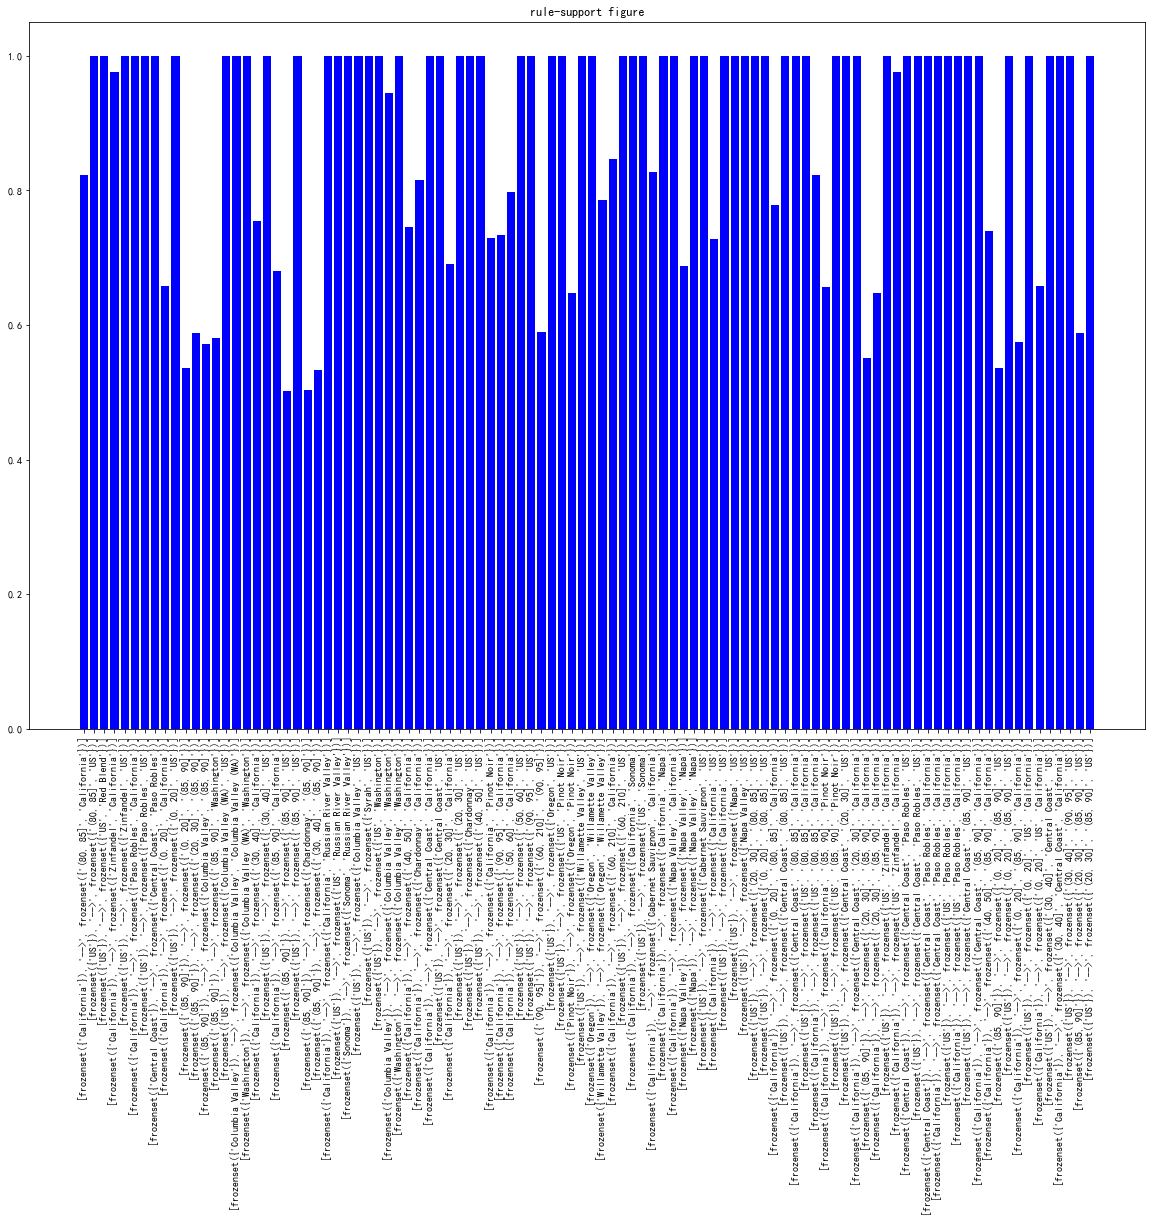

In [21]:
plot_bar(rule, support, 'rule-support figure')

#### 6.2 可视化挖掘出的关联规则对应的置信度

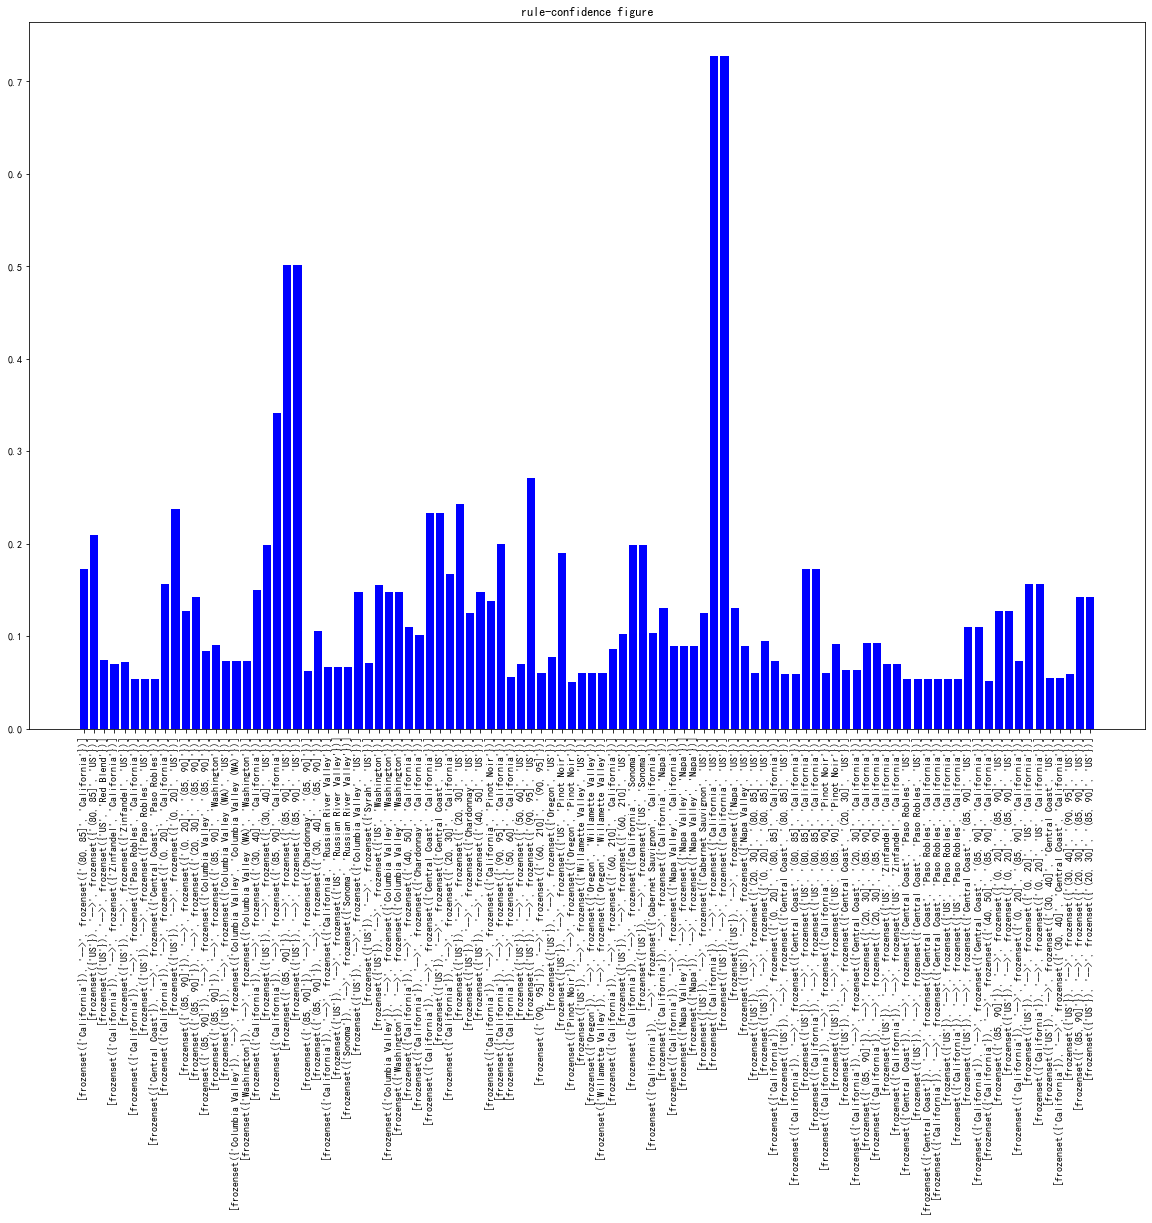

In [22]:
plot_bar(rule, conf, 'rule-confidence figure')